##Importando as bibliotecas

In [ ]:
!pip install streamlit
!pip install arch # install arch package which is usually required for SARIMAGARCH models
!pip install statsmodels # Install statsmodels package, which is also used for time series analysis
!pip install pyspark findspark

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn import metrics
from statsmodels.tools.eval_measures import rmse
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import joblib
from prophet.plot import plot_plotly
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql import Row, DataFrame
from pyspark.sql.types import StringType, StructType, StructField, IntegerType
from pyspark.sql.functions import col, expr, lit, substring, concat, concat_ws, when, coalesce
from pyspark.sql import functions as F # for more sql functions
from functools import reduce

In [ ]:
spark = SparkSession.builder.master("local").appName("BrentOilPrices").getOrCreate()

In [ ]:
brent_oil_prices= spark.read.csv('/content/sample_data/brent_oil_prices.csv', sep = ';', inferSchema = True, header = True)

In [ ]:
brent_oil_prices = brent_oil_prices.withColumnRenamed('Date', 'date')
brent_oil_prices = brent_oil_prices.withColumnRenamed('Europe Brent Spot Price FOB (Dollars per Barrel)', 'price per Barrel')


In [ ]:
brent_oil_prices  = brent_oil_prices.drop('_C2')

In [ ]:
brent_oil_prices.show()

+----------+----------------+
|      date|price per Barrel|
+----------+----------------+
|20/05/1987|           18,63|
|21/05/1987|           18,45|
|22/05/1987|           18,55|
|25/05/1987|           18,60|
|26/05/1987|           18,63|
|27/05/1987|           18,60|
|28/05/1987|           18,60|
|29/05/1987|           18,58|
|01/06/1987|           18,65|
|02/06/1987|           18,68|
|03/06/1987|           18,75|
|04/06/1987|           18,78|
|05/06/1987|           18,65|
|08/06/1987|           18,75|
|09/06/1987|           18,78|
|10/06/1987|           18,78|
|11/06/1987|           18,68|
|12/06/1987|           18,78|
|16/06/1987|           18,90|
|17/06/1987|           19,03|
+----------+----------------+
only showing top 20 rows



In [ ]:
brent_oil_prices.printSchema()

root
 |-- date: string (nullable = true)
 |-- price per Barrel: string (nullable = true)



In [ ]:
null_brent_oil_prices= brent_oil_prices.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in brent_oil_prices.columns])
null_brent_oil_prices.show()

+----+----------------+
|date|price per Barrel|
+----+----------------+
|   0|               0|
+----+----------------+



In [ ]:
brent_oil_prices = brent_oil_prices.toPandas()

In [ ]:

brent_oil_prices['date'] = pd.to_datetime(brent_oil_prices['date'], format='%d/%m/%Y', errors='coerce')

brent_oil_prices['price per Barrel'] = pd.to_numeric(
    brent_oil_prices['price per Barrel'].replace({',': '', ' ': ''}, regex=True),
    errors='coerce'
)

# Scale the prices from cents to dollars by dividing by 100
brent_oil_prices['price per Barrel'] = brent_oil_prices['price per Barrel'] / 100

brent_oil_prices.sort_values(by='date', ascending=False, inplace=True)

print(brent_oil_prices[brent_oil_prices['price per Barrel'].isna()])

print(brent_oil_prices.head())


Empty DataFrame
Columns: [date, price per Barrel]
Index: []
           date  price per Barrel
9516 2024-11-18             74.35
9515 2024-11-15             73.45
9514 2024-11-14             73.39
9513 2024-11-13             72.86
9512 2024-11-12             72.56


In [ ]:
brent_oil_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9517 entries, 9516 to 0
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              9517 non-null   datetime64[ns]
 1   price per Barrel  9517 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 223.1 KB


In [ ]:
brent_oil_prices.sort_index(ascending=False, inplace=True)
brent_oil_prices

,date,price per Barrel
9516,2024-11-18,74.35
9515,2024-11-15,73.45
9514,2024-11-14,73.39
9513,2024-11-13,72.86
9512,2024-11-12,72.56
...,...,...
4,1987-05-26,18.63
3,1987-05-25,18.60
2,1987-05-22,18.55
1,1987-05-21,18.45


In [ ]:
brent_oil_prices = brent_oil_prices.reset_index(drop=True)
brent_oil_prices

,date,price per Barrel
0,2024-11-18,74.35
1,2024-11-15,73.45
2,2024-11-14,73.39
3,2024-11-13,72.86
4,2024-11-12,72.56
...,...,...
9512,1987-05-26,18.63
9513,1987-05-25,18.60
9514,1987-05-22,18.55
9515,1987-05-21,18.45


In [ ]:
train = brent_oil_prices.iloc[:-365]
test = brent_oil_prices.iloc[-365:]

#Modelo A

In [ ]:
# Renomear as colunas para atender ao padrão do Prophet
brent_oil_prices = brent_oil_prices.rename(columns={"date": "ds", "price per Barrel": "y"})

# Garantir que a coluna 'ds' esteja no formato datetime
brent_oil_prices['ds'] = pd.to_datetime(brent_oil_prices['ds'], errors='coerce')

# Remover linhas com valores nulos ou inválidos
brent_oil_prices = brent_oil_prices.dropna(subset=['ds', 'y'])

# Garantir que a coluna 'y' é numérica
brent_oil_prices['y'] = pd.to_numeric(brent_oil_prices['y'], errors='coerce')

In [ ]:
# Criar e ajustar o modelo
mA = Prophet()
mA.fit(brent_oil_prices)

# Criar previsões
future = mA.make_future_dataframe(periods=365)
forecast = mA.predict(future)



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6sf7z4z/nmb1vvp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6sf7z4z/i6wunvmp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84543', 'data', 'file=/tmp/tmpe6sf7z4z/nmb1vvp7.json', 'init=/tmp/tmpe6sf7z4z/i6wunvmp.json', 'output', 'file=/tmp/tmpe6sf7z4z/prophet_modelaph0goqd/prophet_model-20241127105423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:54:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:54:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9877,2025-11-14,93.600636,79.091604,108.086739
9878,2025-11-15,94.915458,80.234656,109.261004
9879,2025-11-16,94.903264,81.138121,109.318660
9880,2025-11-17,93.569364,79.049007,109.034797
9881,2025-11-18,93.442041,79.437766,108.531550


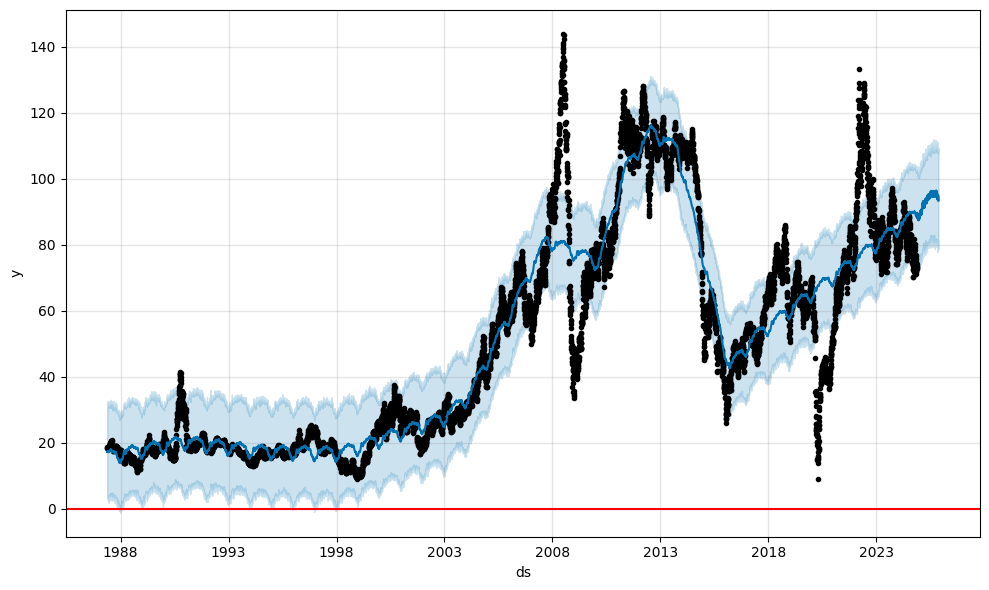

In [ ]:
# Plotando
mA.plot(forecast)
plt.axhline(y=0, color='red')

In [ ]:
plot_plotly(mA, forecast)

In [ ]:
plot_components_plotly(mA, forecast)

/usr/local/lib/python3.10/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [ ]:
# Pegando apenas os ultimos 365 dias
predictionsA = forecast.iloc[-365:]['yhat']

In [ ]:
print("Colunas no DataFrame 'test':", test.columns)

Colunas no DataFrame 'test': Index(['date', 'price per Barrel'], dtype='object')


In [ ]:
print("Root Mean Squared Error entre atuais and valores previstos: ", rmse(predictionsA, test['price per Barrel'])) # Assuming 'price' is the target variable column in your test DataFrame
print("Mean Value os Test Dataset: ", test['price per Barrel'].mean()) # Assuming 'price' is the target variable column in your test DataFrame

Root Mean Squared Error entre atuais and valores previstos:  76.21662735948324
Mean Value os Test Dataset:  16.629205479452054


#Modelo B

In [ ]:
# Criando feriados/periodos especificos
feriados =pd.DataFrame([
    # Eventos históricos relevantes
    {'holiday': 'guerra_golfo', 'ds': '1990-07-15', 'lower_window': 0, 'ds_upper': '1991-01-31'},
    {'holiday': 'crise_2008', 'ds': '2008-07-07', 'lower_window': 0, 'ds_upper': '2008-12-31'},
    {'holiday': 'crise_2014', 'ds': '2014-06-01', 'lower_window': 0, 'ds_upper': '2015-01-01'},
    {'holiday': 'crise_2020', 'ds': '2020-02-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'crise_2022', 'ds': '2022-01-01', 'lower_window': 0, 'ds_upper': '2022-12-31'},

    # Eventos geopolíticos e econômicos recentes
    {'holiday': 'corte_producao_opec', 'ds': '2023-04-03', 'lower_window': 0, 'ds_upper': '2023-06-30'},
    {'holiday': 'guerra_russia_ucrania', 'ds': '2023-07-01', 'lower_window': 0, 'ds_upper': '2023-12-31'},
    {'holiday': 'conflito_oriente_medio', 'ds': '2024-01-01', 'lower_window': 0, 'ds_upper': '2024-03-31'},

    # Novos fatores externos relevantes
    {'holiday': 'pandemia_covid-19', 'ds': '2020-03-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'choque_precos_gas', 'ds': '2021-10-01', 'lower_window': 0, 'ds_upper': '2022-03-01'},
    {'holiday': 'colapso_banco_silicon', 'ds': '2023-03-10', 'lower_window': 0, 'ds_upper': '2023-03-30'},
    {'holiday': 'redução_estoques_petroleo', 'ds': '2024-05-01', 'lower_window': 0, 'ds_upper': '2024-06-30'},
    {'holiday': 'sanções_russia', 'ds': '2024-06-01', 'lower_window': 0, 'ds_upper': '2024-12-31'}
])

for t_col in ['ds', 'ds_upper']:
    feriados[t_col] = pd.to_datetime(feriados[t_col])
feriados['upper_window'] = (feriados['ds_upper'] - feriados['ds']).dt.days
feriados

,holiday,ds,lower_window,ds_upper,upper_window
0,guerra_golfo,1990-07-15,0,1991-01-31,200
1,crise_2008,2008-07-07,0,2008-12-31,177
2,crise_2014,2014-06-01,0,2015-01-01,214
3,crise_2020,2020-02-01,0,2021-03-01,394
4,crise_2022,2022-01-01,0,2022-12-31,364
5,corte_producao_opec,2023-04-03,0,2023-06-30,88
6,guerra_russia_ucrania,2023-07-01,0,2023-12-31,183
7,conflito_oriente_medio,2024-01-01,0,2024-03-31,90
8,pandemia_covid-19,2020-03-01,0,2021-03-01,365
9,choque_precos_gas,2021-10-01,0,2022-03-01,151


In [ ]:
mB = Prophet(holidays=feriados)
mB = mB.fit(brent_oil_prices)
future2 = mB.make_future_dataframe(periods=366)
forecast2 = mB.predict(future2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6sf7z4z/tpjrpic0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6sf7z4z/raq7gnsg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88457', 'data', 'file=/tmp/tmpe6sf7z4z/tpjrpic0.json', 'init=/tmp/tmpe6sf7z4z/raq7gnsg.json', 'output', 'file=/tmp/tmpe6sf7z4z/prophet_model6d8cnxe2/prophet_model-20241127105545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:55:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:01:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(0.5, 1.0, 'Periodos de crise adicionados')

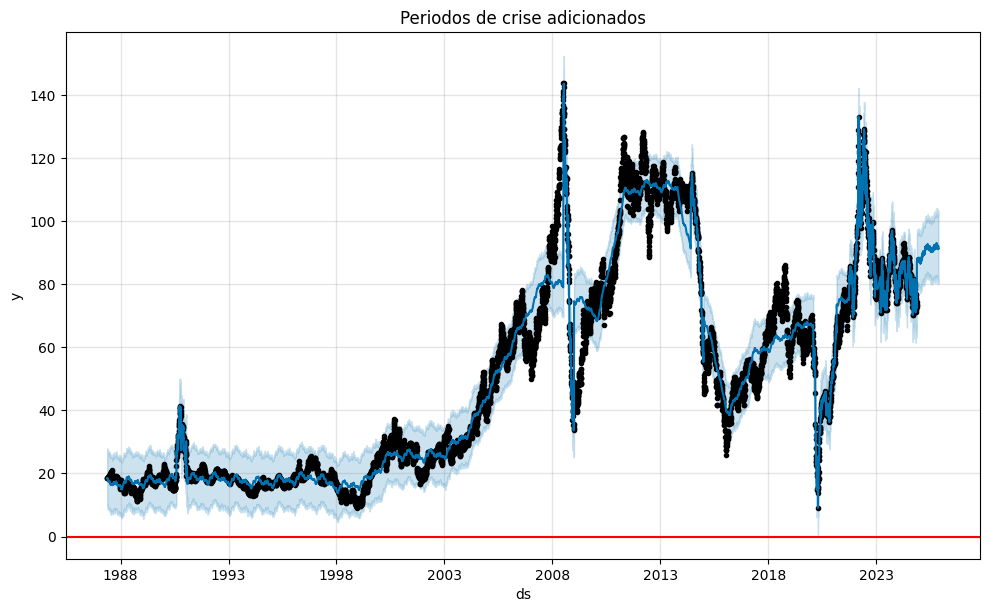

In [ ]:
# Plotando
mB.plot(forecast2)
plt.axhline(y=0, color='red')
plt.title("Periodos de crise adicionados")

In [ ]:
# Pegando apenas os ultimos 365 dias
predictionsB = forecast2.iloc[-365:]['yhat']

In [ ]:
print("Root Mean Squared Error entre atuais and valores previstos: ", rmse(predictionsB, test['price per Barrel']))
print("Mean Value os Test Dataset: ", test['price per Barrel'].mean())

Root Mean Squared Error entre atuais and valores previstos:  73.62061546544673
Mean Value os Test Dataset:  16.629205479452054


#Modelo C

In [ ]:
# Criando feriados/periodos especificos
feriados = pd.DataFrame([
    # Eventos históricos relevantes
    {'holiday': 'guerra_golfo', 'ds': '1990-07-15', 'lower_window': 0, 'ds_upper': '1991-01-31'},
    {'holiday': 'crise_2008', 'ds': '2008-07-07', 'lower_window': 0, 'ds_upper': '2008-12-31'},
    {'holiday': 'crise_2014', 'ds': '2014-06-01', 'lower_window': 0, 'ds_upper': '2015-01-01'},
    {'holiday': 'crise_2020', 'ds': '2020-02-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'crise_2022', 'ds': '2022-01-01', 'lower_window': 0, 'ds_upper': '2022-12-31'},

    # Eventos geopolíticos e econômicos recentes
    {'holiday': 'corte_producao_opec', 'ds': '2023-04-03', 'lower_window': 0, 'ds_upper': '2023-06-30'},
    {'holiday': 'guerra_russia_ucrania', 'ds': '2023-07-01', 'lower_window': 0, 'ds_upper': '2023-12-31'},
    {'holiday': 'conflito_oriente_medio', 'ds': '2024-01-01', 'lower_window': 0, 'ds_upper': '2024-03-31'},

    # Novos fatores externos relevantes
    {'holiday': 'pandemia_covid-19', 'ds': '2020-03-01', 'lower_window': 0, 'ds_upper': '2021-03-01'},
    {'holiday': 'choque_precos_gas', 'ds': '2021-10-01', 'lower_window': 0, 'ds_upper': '2022-03-01'},
    {'holiday': 'colapso_banco_silicon', 'ds': '2023-03-10', 'lower_window': 0, 'ds_upper': '2023-03-30'},
    {'holiday': 'redução_estoques_petroleo', 'ds': '2024-05-01', 'lower_window': 0, 'ds_upper': '2024-06-30'},
    {'holiday': 'sanções_russia', 'ds': '2024-06-01', 'lower_window': 0, 'ds_upper': '2024-12-31'}
])

for t_col in ['ds', 'ds_upper']:
    feriados[t_col] = pd.to_datetime(feriados[t_col])
feriados['upper_window'] = (feriados['ds_upper'] - feriados['ds']).dt.days
feriados

,holiday,ds,lower_window,ds_upper,upper_window
0,guerra_golfo,1990-07-15,0,1991-01-31,200
1,crise_2008,2008-07-07,0,2008-12-31,177
2,crise_2014,2014-06-01,0,2015-01-01,214
3,crise_2020,2020-02-01,0,2021-03-01,394
4,crise_2022,2022-01-01,0,2022-12-31,364
5,corte_producao_opec,2023-04-03,0,2023-06-30,88
6,guerra_russia_ucrania,2023-07-01,0,2023-12-31,183
7,conflito_oriente_medio,2024-01-01,0,2024-03-31,90
8,pandemia_covid-19,2020-03-01,0,2021-03-01,365
9,choque_precos_gas,2021-10-01,0,2022-03-01,151


In [ ]:
mC = Prophet(holidays=feriados)
mC.fit(brent_oil_prices)
future3 = mC.make_future_dataframe(periods=365)
forecast3 = mC.predict(future3)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6sf7z4z/kg_y1_ru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe6sf7z4z/fs4vq9cy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39053', 'data', 'file=/tmp/tmpe6sf7z4z/kg_y1_ru.json', 'init=/tmp/tmpe6sf7z4z/fs4vq9cy.json', 'output', 'file=/tmp/tmpe6sf7z4z/prophet_modelxdi8c7ba/prophet_model-20241127110250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:02:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:08:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Text(0.5, 1.0, 'Periodos de crise adicionados')

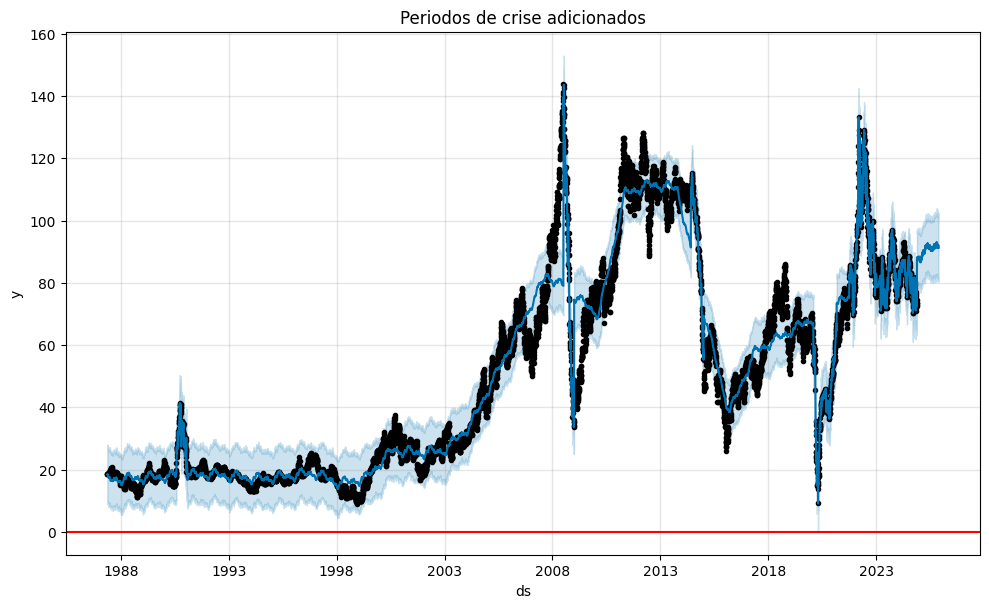

In [ ]:
# Plotando
mC.plot(forecast3)
plt.axhline(y=0, color='red')
plt.title("Periodos de crise adicionados")

In [ ]:
# Pegando apenas os ultimos 365 dias
predictionsC = forecast3.iloc[-365:]['yhat']

In [ ]:
print("Root Mean Squared Error entre atuais and valores previstos: ", rmse(predictionsC, test['price per Barrel']))
print("Mean Value os Test Dataset: ", test['price per Barrel'].mean())

Root Mean Squared Error entre atuais and valores previstos:  73.60953218336985
Mean Value os Test Dataset:  16.629205479452054


In [ ]:
joblib.dump(mC, 'prediction_model')

['prediction_model']

#Comparar modelos

In [ ]:
# Valores reais
y_true = test['price per Barrel'].values  # Certifique-se de que esta coluna contém os valores reais

# Previsões dos modelos anteriores
# Assuming your date column in 'test' is named 'date'
test['ds'] = test['date']  # Create a 'ds' column from your 'date' column
model_predictions = {
    "Model A": predictionsA,  # Substitua pelas previsões do Modelo A
    "Model B": predictionsB,  # Substitua pelas previsões do Modelo B
    "Model C": predictionsC,  # Substitua pelas previsões do Modelo C
}
# Inicializar DataFrame para resultados
evaluation_results = []

# Avaliação de cada modelo
for model_name, predictions in model_predictions.items():
    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    mae = mean_absolute_error(y_true, predictions)
    r2 = r2_score(y_true, predictions)

    # Adicionar resultados ao DataFrame
    evaluation_results.append({
        "Model": model_name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

# Converter resultados para DataFrame
results_df = pd.DataFrame(evaluation_results)

# Exibir resultados
print("Comparação de Modelos:")
print(results_df.sort_values(by="RMSE"))  # Ordenar por RMSE para identificar o melhor modelo

Comparação de Modelos:
     Model       RMSE        MAE           R²
2  Model C  73.609532  73.592932 -1259.114604
1  Model B  73.620615  73.603952 -1259.494100
0  Model A  76.216627  76.201925 -1349.956557


<ipython-input-142-da20ab9d527d>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

